Given the approval of composite forecasting approach, the models built on individual circuits needs to be optimized using feature selection and hyper parameter tuning. 


	1. Feature Selection: the feature selection method would be carried out in 3 steps.
		a. The first two would be implementation of the two types of feature selection method employed suitable as per the respective models of the circuits. 
		b. The third step is to implement shapely values.
		c. The features that are in consensus with the three steps will be selected for further hyperparameter tuning

	2. Hyper-parameter tuning: Depending on the respective model for the circuits hyper parameter tuning will be performed. 

	3. Robust validation: given the models, validation sets needs to be created from different time and season of the data to check the performance of the respective models. Add new performance metrics


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression


from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

import plotly
import plotly.graph_objects as go

In [12]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [1]:
from joblib import dump, load

In [7]:
np.random.seed(45)

In [2]:
assets_path = ".././assets/"

In [3]:
model_artifacts = load(assets_path + "model_artifacts.joblib")

### Prepare data

In [9]:
data_path = ".././data/"
file_name = "data.csv"
data = pd.read_csv(data_path + file_name)
data.head()

,time,Comms and Services,Space Heating,Hot Water,Sockets,Lighting,Bld_EngCons,Car Chargers,weekend,bank holiday,...,forecastperiod,forecast_temperature,forecast_feelslike,forecast_weathertype,forecast_windspeed,forecast_uvindex,forecast_precipitationprobability,forecast_winddirection,forecast_visibility,forecast_interval
0,2019-04-01 00:00:00+00,0.515253,0.856489,0.000000,0.051467,0.124797,1.548006,0.032239,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-04-01 01:00:00+00,0.687381,0.786147,0.085386,0.050931,0.151708,1.761553,0.042894,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-04-01 02:00:00+00,0.687678,3.530669,0.099239,0.055706,0.151233,4.524525,0.043100,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-04-01 03:00:00+00,0.690139,4.044003,0.098467,0.050019,0.151436,5.034064,0.043131,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-04-01 04:00:00+00,0.687081,4.223769,0.091533,0.050142,0.151331,5.203856,0.043031,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# rename the columns to make it easier for accessing
new_col_names_map =  {i: i.lower().replace(" ", "_") for i in data.columns}
data = data.rename(columns=new_col_names_map)
# set the timestamp as the index for easy access of the data
data = data.set_index("time")
# subset the dataset to load only the post covid dataset
data = data[data.index >= "2021-01-01"]

circuit_columns = [
    "comms_and_services", "space_heating", "hot_water", "sockets", "lighting", "car_chargers"
]
data[circuit_columns].isna().sum()

# interpolate only the cirucit columns to consider for decomposition plot
for column in circuit_columns:
    data[column] = data[column].interpolate(method="linear", limit_direction="both")

data[circuit_columns].isna().sum()

missing_columns = pd.DataFrame(data.isna().sum().reset_index())
missing_columns = missing_columns[missing_columns[0] > 0]
missing_columns = missing_columns["index"].tolist()

# impute the data
for column in missing_columns:
    data[column] = data[column].interpolate(method="linear", limit_direction="both")

data.isna().sum()

# drop the forecastperiod column
data = data.drop(columns=["forecastperiod", "forecast_interval", "forecast_datadate"], axis=0)
data.shape

# transform the forecast visibility

# Reference
# https://www.metoffice.gov.uk/weather/guides/what-does-this-forecast-mean#:~:text=Visibility%20measures%20the%20distance%20at,Less%20than%201%2C000%20metres
visibility_map = {
    "EX": 6, "VG": 5, "GO": 4, "MO": 3, "PO": 2, "VP": 1
}

data["forecast_visibility"] = data["forecast_visibility"].map(visibility_map)
data["forecast_visibility"].head()


# forecast winddirection convertion to degrees 
data = data.copy()
degrees_map = pd.read_csv(".././data/degrees.csv", sep=",")
degrees_lookup = {abbrv: deg for abbrv, deg in zip(degrees_map["Abbrv."], degrees_map["Degrees"])}
data["forecast_winddirection"] = data["forecast_winddirection"].map(degrees_lookup)
data["forecast_winddirection"].value_counts()


# cyclic transformations
denom_map = {
    "hour": 24, "month": 12, "day_of_week": 7, "forecast_winddirection": 360
}

for col_name in denom_map:
    print(col_name)
    data[f"sine_{col_name}"] = np.sin(2 * np.pi * data[col_name] / denom_map[col_name])
    data[f"cos_{col_name}"] = np.cos(2 * np.pi * data[col_name] / denom_map[col_name])


# boolean transformation
data["weekend"] = data["weekend"].astype(int)
data["bank_holiday"] = data["bank_holiday"].astype(int)


hour
month
day_of_week
forecast_winddirection


C:\Users\akson\AppData\Local\Temp\ipykernel_12596\1377559194.py:26: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data[column] = data[column].interpolate(method="linear", limit_direction="both")


In [13]:
data.head()

,comms_and_services,space_heating,hot_water,sockets,lighting,bld_engcons,car_chargers,weekend,bank_holiday,hour,...,forecast_winddirection,forecast_visibility,sine_hour,cos_hour,sine_month,cos_month,sine_day_of_week,cos_day_of_week,sine_forecast_winddirection,cos_forecast_winddirection
time,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00,0.591504,3.425193,0.000000,0.049433,0.154873,4.221002,0.0,0,1,0,...,0.0,5.0,0.000000,1.000000,0.5,0.866025,-0.974928,-0.222521,0.000000,1.00000
2021-01-01 01:00:00+00,0.591203,4.012907,0.000000,0.047753,0.154846,4.806708,0.0,0,1,1,...,0.0,5.0,0.258819,0.965926,0.5,0.866025,-0.974928,-0.222521,0.000000,1.00000
2021-01-01 02:00:00+00,0.591666,5.342417,0.444782,0.051869,0.154997,6.585732,0.0,0,1,2,...,0.0,5.0,0.500000,0.866025,0.5,0.866025,-0.974928,-0.222521,0.000000,1.00000
2021-01-01 03:00:00+00,0.591278,5.756598,0.000000,0.043028,0.154626,6.545530,0.0,0,1,3,...,337.5,5.0,0.707107,0.707107,0.5,0.866025,-0.974928,-0.222521,-0.382683,0.92388
2021-01-01 04:00:00+00,0.591354,5.415492,0.000000,0.050306,0.154498,6.211650,0.0,0,1,4,...,337.5,5.0,0.866025,0.500000,0.5,0.866025,-0.974928,-0.222521,-0.382683,0.92388


In [14]:
data.to_csv("transformed_data.csv", index=False)

In [11]:
def create_std_scaler(data, column_name):
    data_scaler = StandardScaler()
    if isinstance(column_name, str):
        column_name = [column_name]
    data_scaler = data_scaler.fit(data[column_name])
    transformed_data = data.copy()
    transformed_data[column_name] = data_scaler.transform(data[column_name])
    scaling_info = pd.DataFrame({
        "columns": column_name,
        "mean": data_scaler.mean_,
        "variance": data_scaler.var_,
        "scale_factor": data_scaler.scale_
    })
    print(scaling_info)
    return data_scaler, transformed_data[column_name]

In [42]:
def calculate_smape(actual, predicted) -> float: 
  
    # Convert actual and predicted to numpy 
    # array data type if not already 
    if not all([isinstance(actual, np.ndarray),  
                isinstance(predicted, np.ndarray)]): 
        actual, predicted = np.array(actual), np.array(predicted) 
  
    return round( 
        np.mean( 
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2) 
        )*100, 2
    )

def calculate_norm_rmse(actual, predicted, min_max=False) -> float:
    score = sqrt(mean_squared_error(actual, predicted))
    norm_score = score / (actual.max() - actual.min())
    return norm_score

def cal_metrics(actual, predictions):
    perf_metrics = pd.DataFrame({
        "MAE": [mean_absolute_error(actual, predictions)],
        "MAPE": [round(mean_absolute_percentage_error(actual, predictions) * 100, 2)],
        "R2_Score": [r2_score(actual, predictions)],
        "SMAPE": [calculate_smape(actual, predictions)],
        "nRMSE": [calculate_norm_rmse(actual, predictions)]
    })
    return perf_metrics

## Feature selection

### Comms and services

The comms and services used multiple linear regression and for feature selection LASSO regression is implemented.

#### Feature selection: LASSO

In [201]:
column_name = ["comms_and_services", 'weekend', 'bank_holiday',
       'hour', 'day_of_week', 'day_of_month', 'month', 'year',
       'forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_winddirection',
       'forecast_visibility', 'sine_hour', 'cos_hour', 'sine_month',
       'cos_month', 'sine_day_of_week', 'cos_day_of_week',
       'sine_forecast_winddirection', 'cos_forecast_winddirection', "y"]

# transform the data
cs_data = data.copy()
cs_data["y"] = cs_data[column_name[0]].shift(-1)
cs_data = cs_data.dropna(axis=0)
cs_data_scaler, transformed_data = create_std_scaler(cs_data, column_name[:-1])
cs_target_scaler, transformed_iv_data = create_std_scaler(cs_data, column_name[-1])

cs_transformed_data = pd.concat(
    [transformed_data, transformed_iv_data], axis=1, ignore_index=False
)

# Training and testing data for comms and services
cs_train_data = cs_transformed_data[cs_transformed_data.index < '2023-12-01'][column_name]
cs_test_data = cs_transformed_data[cs_transformed_data.index >= '2023-12-01'][column_name]
cs_train_data.shape, cs_test_data.shape

                              columns         mean     variance  scale_factor
0                  comms_and_services     0.512007     0.003915      0.062573
1                             weekend     0.286993     0.204628      0.452358
2                        bank_holiday     0.025213     0.024577      0.156772
3                                hour    11.535115    47.970256      6.926056
4                         day_of_week     2.990234     4.013484      2.003368
5                        day_of_month    15.761721    77.705100      8.815050
6                               month     6.521380    11.891658      3.448428
7                                year  2022.015369     0.664680      0.815279
8                forecast_temperature    11.857710    21.556696      4.642919
9                  forecast_feelslike     9.363177    29.404385      5.422581
10               forecast_weathertype     6.340998    23.527392      4.850504
11                 forecast_windspeed    15.113147    51.363798 

((24958, 25), (743, 25))

In [17]:
from sklearn.linear_model import Lasso

In [36]:
lasso_clf = Lasso(alpha=0.1)
lasso_fit = lasso_clf.fit(cs_train_data[column_name[:-1]], cs_train_data[column_name[-1]])

In [37]:
importance = np.abs(lasso_fit.coef_)
np.array(column_name[:-1])[importance > 0]

array(['comms_and_services'], dtype='<U33')

In [38]:
cs_test_data["predictions"] = lasso_fit.predict(cs_test_data[column_name[:-1]])

In [43]:
cal_metrics(cs_test_data["y"].to_numpy(), cs_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.188963,14.89,-58.450264,16.1,1.162091


#### Feature selection: SelectKbest + mutual_info_regression

In [47]:
from sklearn.feature_selection import SelectKBest, mutual_info_regression

In [59]:
feature_selector = SelectKBest(mutual_info_regression, k=9)
fs_fit = feature_selector.fit(cs_train_data[column_name[:-1]], cs_train_data[column_name[-1]])

In [60]:
np.array(column_name[:-1])[fs_fit.get_support() == True]

array(['comms_and_services', 'day_of_month', 'month', 'year',
       'forecast_temperature', 'forecast_feelslike',
       'forecast_precipitationprobability', 'sine_month', 'cos_month'],
      dtype='<U33')

#### Feature selection: SHAP

In [ ]:
import shap

In [64]:
multi_lin_reg = LinearRegression()
multi_lin_reg_fit = multi_lin_reg.fit(cs_train_data[column_name[:-1]], cs_train_data[column_name[-1]])

In [65]:
X100 = shap.utils.sample(cs_test_data[column_name[:-1]], 100)  # 100 instances for use as the background distribution

In [67]:
explainer = shap.Explainer(multi_lin_reg_fit.predict, X100)
shap_values = explainer(cs_test_data[column_name[:-1]])

PermutationExplainer explainer: 24959it [12:16, 33.66it/s]                                                             


In [68]:
sample_ind = 45

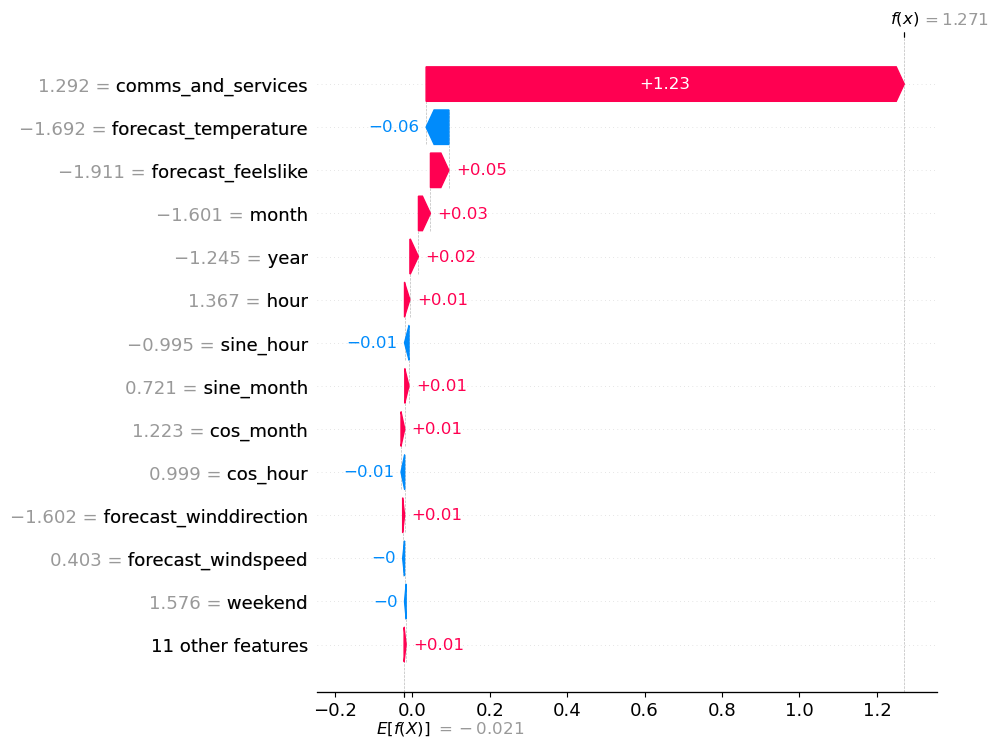

In [69]:
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

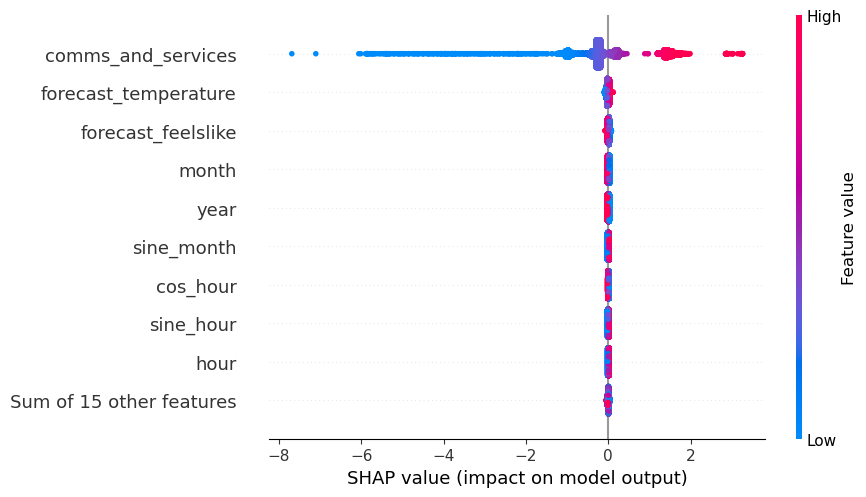

In [70]:
shap.plots.beeswarm(shap_values)

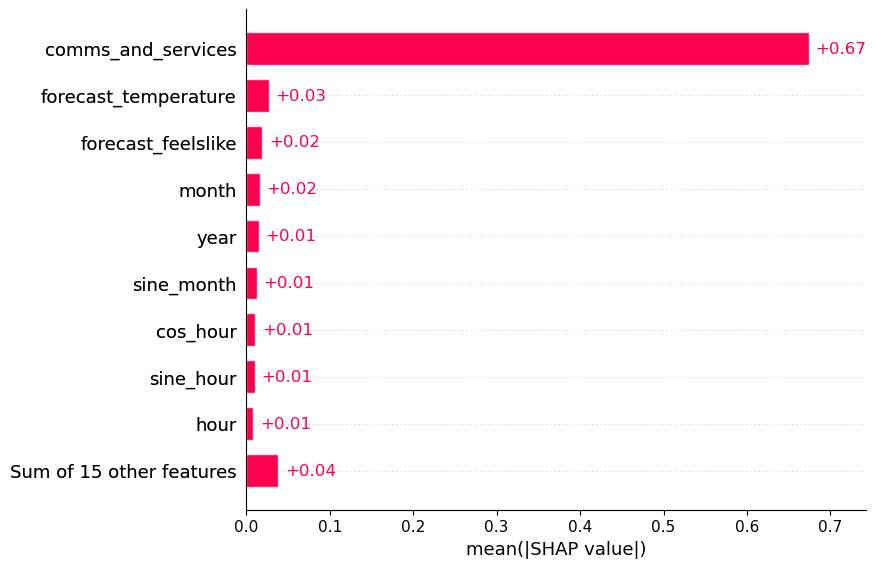

In [71]:
shap.plots.bar(shap_values)

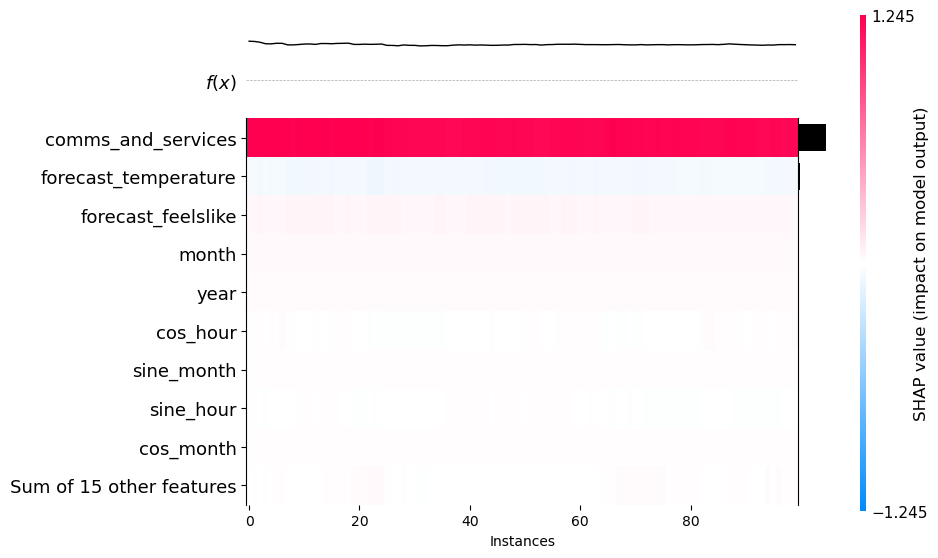

In [73]:
shap.plots.heatmap(shap_values[:100])

#### Without feature selection

In [62]:
multi_lin_reg = LinearRegression()
multi_lin_reg_fit = multi_lin_reg.fit(cs_train_data[column_name[:-1]], cs_train_data[column_name[-1]])
cs_test_data["predictions"] = multi_lin_reg_fit.predict(cs_test_data[column_name[:-1]])
cal_metrics(cs_test_data["y"].to_numpy(), cs_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.029255,2.31,-0.948951,2.35,0.210409


#### With feature selection

In [74]:
# features are shortlisted based on the consensus from the feature selection methods
shortlisted_features = ['comms_and_services', 'month', 'year', 'forecast_temperature', 'forecast_feelslike'] + ["y"]

In [75]:
multi_lin_reg = LinearRegression()
multi_lin_reg_fit = multi_lin_reg.fit(cs_train_data[shortlisted_features[:-1]], cs_train_data[shortlisted_features[-1]])
cs_test_data["predictions"] = multi_lin_reg_fit.predict(cs_test_data[shortlisted_features[:-1]])
cal_metrics(cs_test_data["y"].to_numpy(), cs_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.016801,1.32,0.313655,1.33,0.124863


### Space heating

The space heating circuits used multiple regression and for faature selection LASSO regression is implemented

#### Feature Selection: LASSO

In [202]:
column_name = ["space_heating", 'weekend', 'bank_holiday',
       'hour', 'day_of_week', 'day_of_month', 'month', 'year',
       'forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_winddirection',
       'forecast_visibility', 
       'sine_forecast_winddirection', 'cos_forecast_winddirection', "y"]

# 'sine_hour', 'cos_hour', 'sine_month', 'cos_month', 'sine_day_of_week', 'cos_day_of_week'

# transform the data
sh_data = data.copy()
sh_data["y"] = sh_data[column_name[0]].shift(-1)
sh_data = sh_data.dropna(axis=0)
sh_data_scaler, sh_transformed_data = create_std_scaler(sh_data, column_name[:-1])
sh_target_scaler, sh_transformed_target_data = create_std_scaler(sh_data, column_name[-1])

sh_transformed_data = pd.concat([sh_transformed_data, sh_transformed_target_data],ignore_index=False, axis=1)

# # Training and testing data for comms and services
sh_train_data = sh_transformed_data[sh_transformed_data.index < '2023-12-01'][column_name]
sh_test_data = sh_transformed_data[sh_transformed_data.index >= '2023-12-01'][column_name]
sh_train_data.shape, sh_test_data.shape

                              columns         mean     variance  scale_factor
0                       space_heating     0.926123     1.421973      1.192465
1                             weekend     0.286993     0.204628      0.452358
2                        bank_holiday     0.025213     0.024577      0.156772
3                                hour    11.535115    47.970256      6.926056
4                         day_of_week     2.990234     4.013484      2.003368
5                        day_of_month    15.761721    77.705100      8.815050
6                               month     6.521380    11.891658      3.448428
7                                year  2022.015369     0.664680      0.815279
8                forecast_temperature    11.857710    21.556696      4.642919
9                  forecast_feelslike     9.363177    29.404385      5.422581
10               forecast_weathertype     6.340998    23.527392      4.850504
11                 forecast_windspeed    15.113147    51.363798 

((24958, 19), (743, 19))

In [104]:
lasso_clf = Lasso(alpha=0.1)
lasso_fit = lasso_clf.fit(sh_train_data[column_name[:-1]], sh_train_data[column_name[-1]])
importance = np.abs(lasso_fit.coef_)
np.array(column_name[:-1])[importance > 0]

array(['space_heating', 'forecast_temperature', 'forecast_feelslike'],
      dtype='<U33')

In [105]:
sh_test_data["predictions"] = lasso_fit.predict(sh_test_data[column_name[:-1]])
cal_metrics(sh_test_data["y"].to_numpy(), sh_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.340005,328.31,0.643228,75.34,0.099252


#### Feature selection: SelectKbest + mutual_info_regression

In [106]:
feature_selector = SelectKBest(mutual_info_regression, k=9)
fs_fit = feature_selector.fit(sh_train_data[column_name[:-1]], sh_train_data[column_name[-1]])

In [107]:
np.array(column_name[:-1])[fs_fit.get_support() == True]

array(['space_heating', 'hour', 'month', 'year', 'forecast_temperature',
       'forecast_feelslike', 'forecast_weathertype', 'forecast_uvindex',
       'forecast_winddirection'], dtype='<U33')

#### Feature selection: SHAP

In [108]:
multi_lin_reg = LinearRegression()
multi_lin_reg_fit = multi_lin_reg.fit(sh_train_data[column_name[:-1]], sh_train_data[column_name[-1]])

In [109]:
X100 = shap.utils.sample(sh_test_data[column_name[:-1]], 100)  # 100 instances for use as the background distribution

In [110]:
explainer = shap.Explainer(multi_lin_reg_fit.predict, X100)
shap_values = explainer(sh_test_data[column_name[:-1]])

PermutationExplainer explainer: 24959it [15:20, 26.79it/s]                                                             


In [111]:
sample_ind = 45

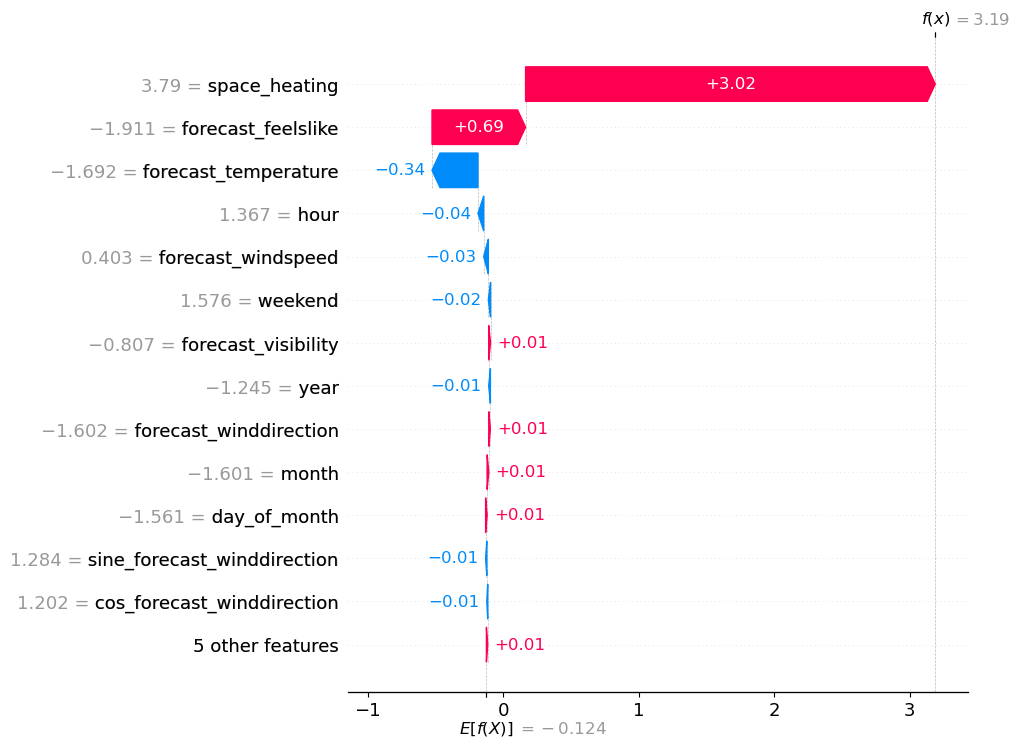

In [112]:
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

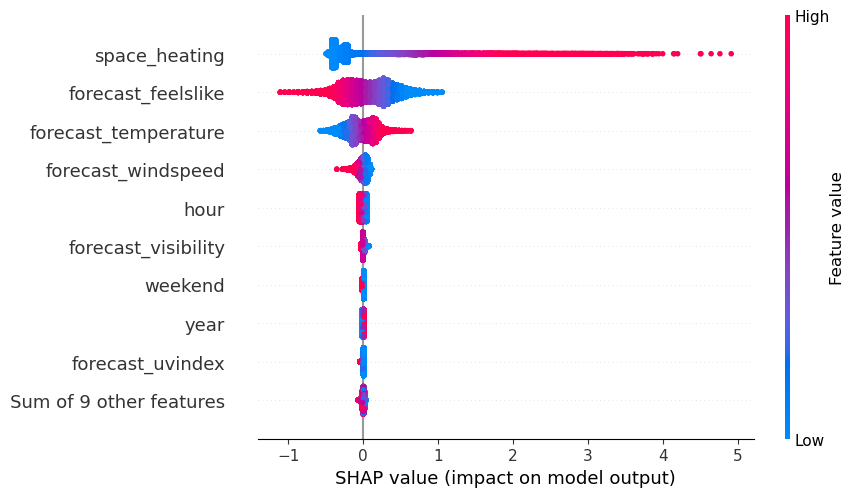

In [113]:
shap.plots.beeswarm(shap_values)

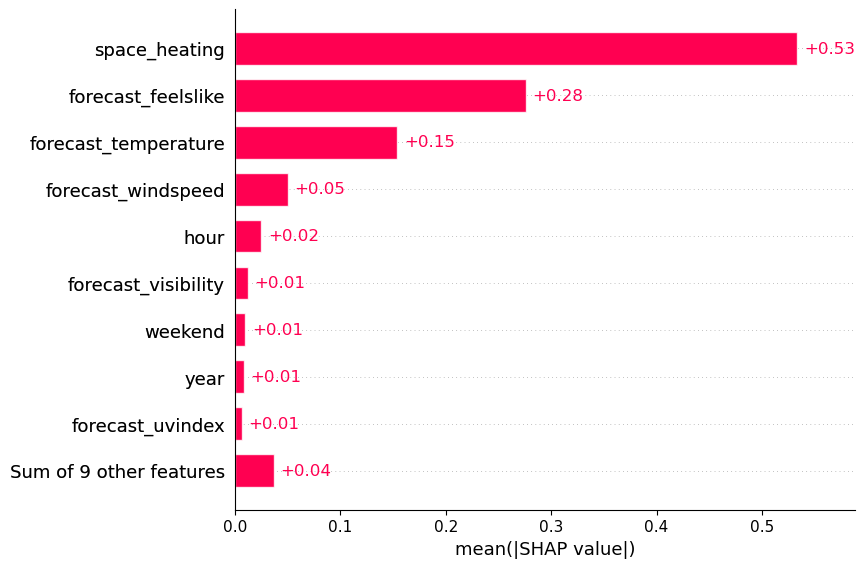

In [114]:
shap.plots.bar(shap_values)

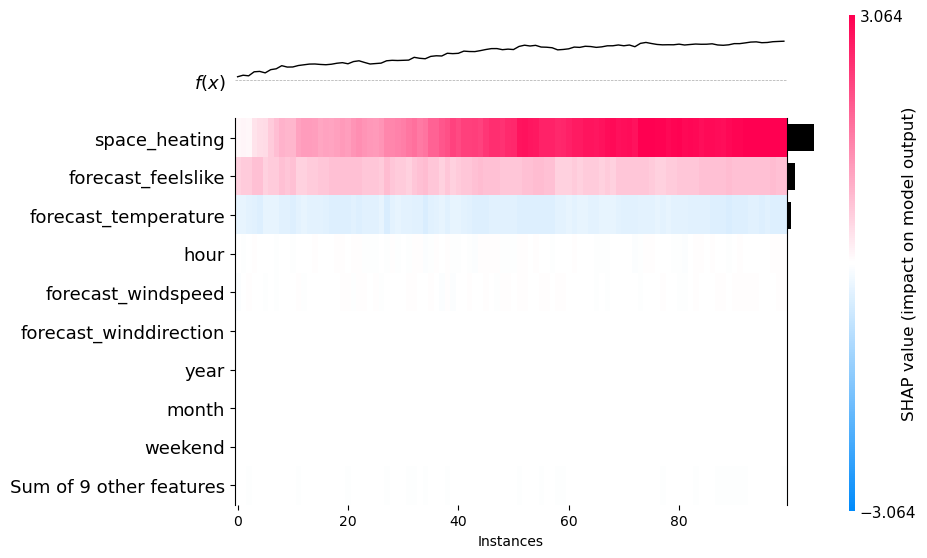

In [115]:
shap.plots.heatmap(shap_values[:100])

#### Without feature selection

In [116]:
multi_lin_reg = LinearRegression()
multi_lin_reg_fit = multi_lin_reg.fit(sh_train_data[column_name[:-1]], sh_train_data[column_name[-1]])
sh_test_data["predictions"] = multi_lin_reg_fit.predict(sh_test_data[column_name[:-1]])
cal_metrics(sh_test_data["y"].to_numpy(), sh_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.32333,362.34,0.660914,73.0,0.09676


#### With feature selection

In [132]:
# features are shortlisted based on the consensus from the feature selection methods
shortlisted_features = ['space_heating', 'forecast_feelslike', 'forecast_temperature', 'hour', 'forecast_windspeed', "month"] + ["y"]

In [133]:
multi_lin_reg = LinearRegression()
multi_lin_reg_fit = multi_lin_reg.fit(sh_train_data[shortlisted_features[:-1]], sh_train_data[shortlisted_features[-1]])
sh_test_data["predictions"] = multi_lin_reg_fit.predict(sh_test_data[shortlisted_features[:-1]])
cal_metrics(sh_test_data["y"].to_numpy(), sh_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.324401,356.49,0.657622,72.74,0.097229


### Car chargers

In [142]:
column_name = ["car_chargers", 'weekend', 'bank_holiday',
       'hour', 'day_of_week', 'day_of_month', 'month', 'year',
       'forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_winddirection',
       'forecast_visibility', "y"]

# 'sine_hour', 'cos_hour', 'sine_month', 'cos_month', 'sine_day_of_week', 'cos_day_of_week', 'sine_forecast_winddirection', 'cos_forecast_winddirection'

# transform the data
cc_data = data.copy()
cc_data["y"] = cc_data[column_name[0]].shift(-1)
cc_data = cc_data.dropna(axis=0)
cc_data_scaler, cc_transformed_data = create_std_scaler(cc_data, column_name[:-1])
cc_target_scaler, cc_transformed_target_data = create_std_scaler(cc_data, column_name[-1])

cc_transformed_data = pd.concat([cc_transformed_data, cc_transformed_target_data], ignore_index=False, axis=1)

# # Training and testing data for comms and services
cc_train_data = cc_transformed_data[cc_transformed_data.index < '2023-12-01'][column_name]
cc_test_data = cc_transformed_data[cc_transformed_data.index >= '2023-12-01'][column_name]
cc_train_data.shape, cc_test_data.shape

                              columns         mean     variance  scale_factor
0                        car_chargers     1.054399     9.303331      3.050136
1                             weekend     0.286993     0.204628      0.452358
2                        bank_holiday     0.025213     0.024577      0.156772
3                                hour    11.535115    47.970256      6.926056
4                         day_of_week     2.990234     4.013484      2.003368
5                        day_of_month    15.761721    77.705100      8.815050
6                               month     6.521380    11.891658      3.448428
7                                year  2022.015369     0.664680      0.815279
8                forecast_temperature    11.857710    21.556696      4.642919
9                  forecast_feelslike     9.363177    29.404385      5.422581
10               forecast_weathertype     6.340998    23.527392      4.850504
11                 forecast_windspeed    15.113147    51.363798 

((24958, 17), (743, 17))

#### Feature selection: LASSO

In [143]:
lasso_clf = Lasso(alpha=0.1)
lasso_fit = lasso_clf.fit(cc_train_data[column_name[:-1]], cc_train_data[column_name[-1]])
importance = np.abs(lasso_fit.coef_)
np.array(column_name[:-1])[importance > 0]

array(['car_chargers'], dtype='<U33')

#### Feature selection: SelectKBest + mutual_info_regression

In [144]:
feature_selector = SelectKBest(mutual_info_regression, k=9)
fs_fit = feature_selector.fit(cc_train_data[column_name[:-1]], cc_train_data[column_name[-1]])

In [145]:
np.array(column_name[:-1])[fs_fit.get_support() == True]

array(['car_chargers', 'weekend', 'hour', 'day_of_week', 'day_of_month',
       'month', 'year', 'forecast_weathertype', 'forecast_uvindex'],
      dtype='<U33')

#### Feature selection: SHAP

In [146]:
multi_lin_reg = LinearRegression()
multi_lin_reg_fit = multi_lin_reg.fit(cc_train_data[column_name[:-1]], cc_train_data[column_name[-1]])

In [147]:
X100 = shap.utils.sample(cc_test_data[column_name[:-1]], 100)  # 100 instances for use as the background distribution

In [148]:
explainer = shap.Explainer(multi_lin_reg_fit.predict, X100)
shap_values = explainer(cc_test_data[column_name[:-1]])

PermutationExplainer explainer: 24959it [13:11, 31.06it/s]                                                             


In [149]:
sample_ind = 45

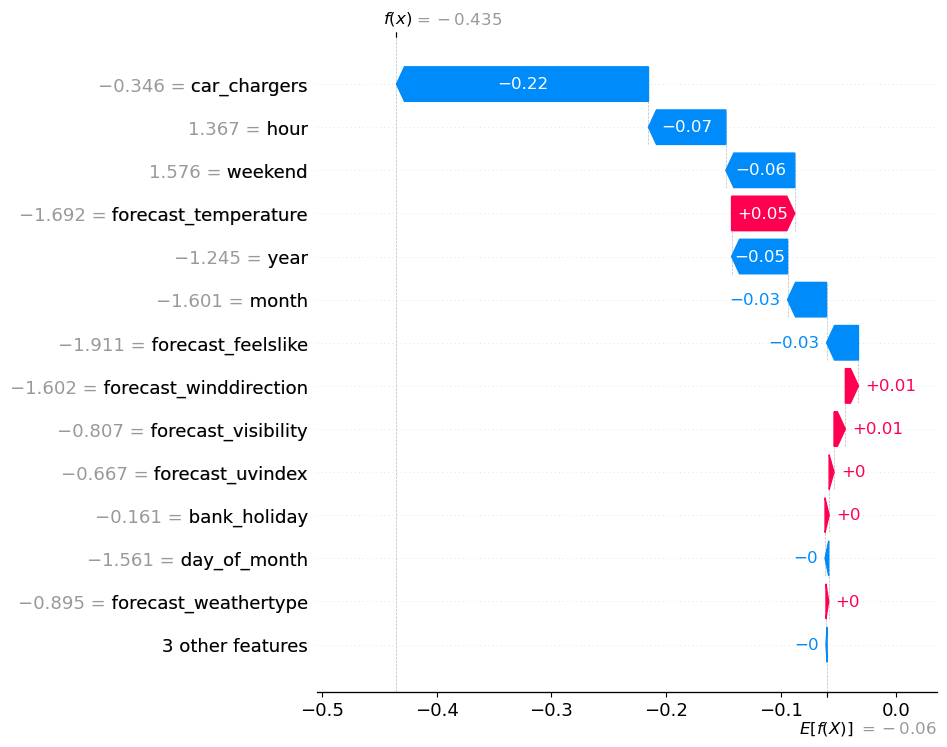

In [150]:
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

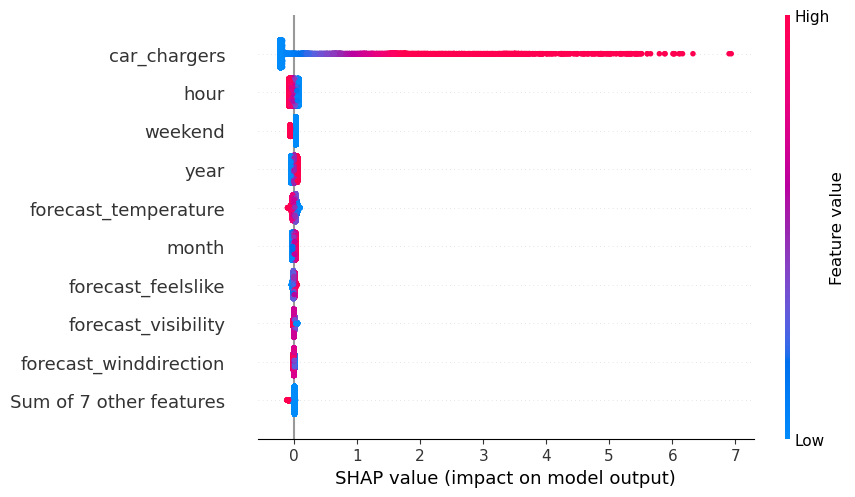

In [151]:
shap.plots.beeswarm(shap_values)

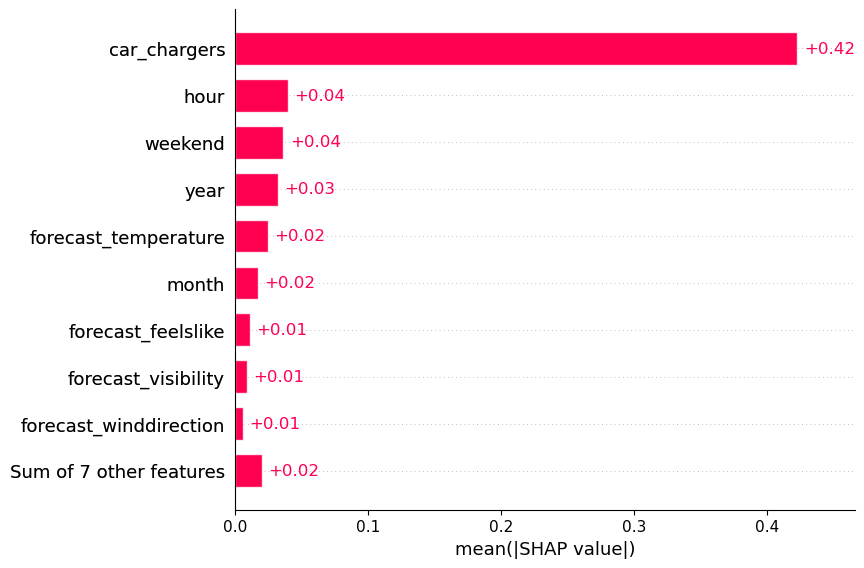

In [152]:
shap.plots.bar(shap_values)

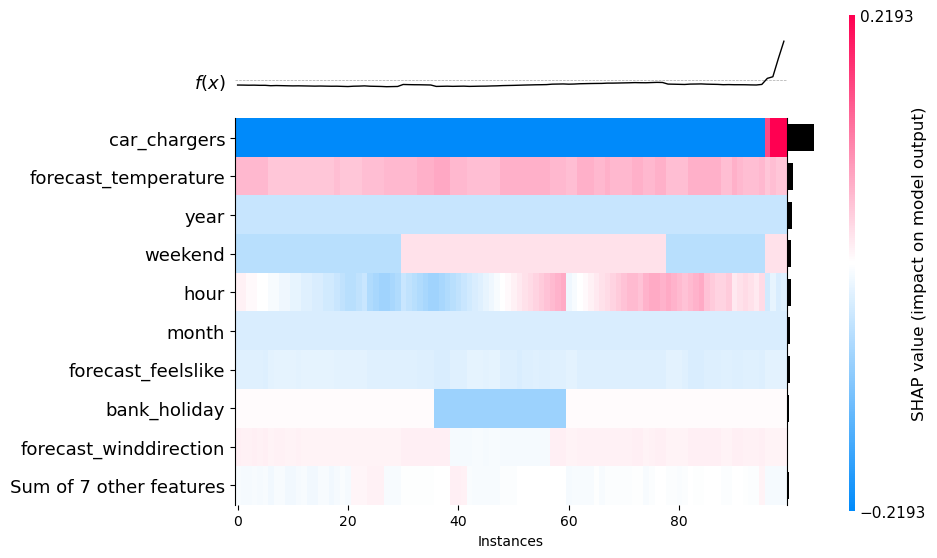

In [153]:
shap.plots.heatmap(shap_values[:100])

#### Without feature selection

In [154]:
multi_lin_reg = LinearRegression()
multi_lin_reg_fit = multi_lin_reg.fit(cc_train_data[column_name[:-1]], cc_train_data[column_name[-1]])
cc_test_data["predictions"] = multi_lin_reg_fit.predict(cc_test_data[column_name[:-1]])
cal_metrics(cc_test_data["y"].to_numpy(), cc_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.346398,71.89,0.752591,65.5,0.089278


#### With feature selection

In [161]:
# features are shortlisted based on the consensus from the feature selection methods
shortlisted_features = ['car_chargers', "forecast_temperature", 'weekend', 'hour', 'day_of_week', 'forecast_feelslike'] + ["y"]

In [162]:
multi_lin_reg = LinearRegression()
multi_lin_reg_fit = multi_lin_reg.fit(cc_train_data[shortlisted_features[:-1]], cc_train_data[shortlisted_features[-1]])
cc_test_data["predictions"] = multi_lin_reg_fit.predict(cc_test_data[shortlisted_features[:-1]])
cal_metrics(cc_test_data["y"].to_numpy(), cc_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.295266,55.6,0.752571,40.62,0.089282


### All others

#### Feature selection: Random forest regressor

In [163]:
col_name = [
    'hot_water', 'sockets','lighting', 'weekend', 'bank_holiday',
       'hour', 'day_of_week', 'day_of_month', 'month', 'year',
       'forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_winddirection',
       'forecast_visibility']
bldg_data = data[col_name]
bldg_data["total_load"] = bldg_data[['hot_water', 'sockets','lighting']].sum(axis=1)
column_name =   [
    "total_load", 'weekend', 'bank_holiday',
       'hour', 'day_of_week', 'day_of_month', 'month', 'year',
       'forecast_temperature', 'forecast_feelslike', 'forecast_weathertype',
       'forecast_windspeed', 'forecast_uvindex',
       'forecast_precipitationprobability', 'forecast_winddirection',
       'forecast_visibility', "y"
]

# transform the data
bldg_data["y"] = bldg_data[column_name[0]].shift(-1)
bldg_data = bldg_data.dropna(axis=0)
bldg_data_scaler, bldg_transformed_data = create_std_scaler(bldg_data, column_name[:-1])
bldg_target_scaler, bldg_transformed_target_data = create_std_scaler(bldg_data, column_name[-1])

bldg_transformed_data = pd.concat([bldg_transformed_data, bldg_transformed_target_data], ignore_index=False, axis=1)

# # Training and testing data for comms and services
bldg_train_data = bldg_transformed_data[bldg_transformed_data.index < '2023-12-01'][column_name]
bldg_test_data = bldg_transformed_data[bldg_transformed_data.index >= '2023-12-01'][column_name]
bldg_train_data.shape, bldg_test_data.shape

                              columns         mean     variance  scale_factor
0                          total_load     0.498093     0.332070      0.576255
1                             weekend     0.286993     0.204628      0.452358
2                        bank_holiday     0.025213     0.024577      0.156772
3                                hour    11.535115    47.970256      6.926056
4                         day_of_week     2.990234     4.013484      2.003368
5                        day_of_month    15.761721    77.705100      8.815050
6                               month     6.521380    11.891658      3.448428
7                                year  2022.015369     0.664680      0.815279
8                forecast_temperature    11.857710    21.556696      4.642919
9                  forecast_feelslike     9.363177    29.404385      5.422581
10               forecast_weathertype     6.340998    23.527392      4.850504
11                 forecast_windspeed    15.113147    51.363798 

C:\Users\akson\AppData\Local\Temp\ipykernel_12596\262722402.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bldg_data["total_load"] = bldg_data[['hot_water', 'sockets','lighting']].sum(axis=1)
C:\Users\akson\AppData\Local\Temp\ipykernel_12596\262722402.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bldg_data["y"] = bldg_data[column_name[0]].shift(-1)


((24958, 17), (743, 17))

In [164]:
from sklearn.ensemble import RandomForestRegressor

In [165]:
rf_reg = RandomForestRegressor()
rf_reg_fit = rf_reg.fit(bldg_train_data[column_name[:-1]], bldg_train_data[column_name[-1]])

In [176]:
importances = rf_reg_fit.feature_importances_

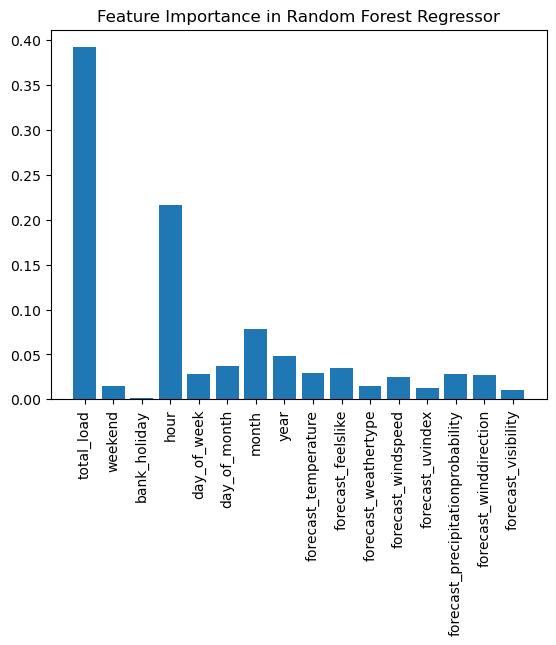

In [175]:
plt.bar(range(bldg_train_data[column_name[:-1]].shape[1]), importances)
plt.xticks(range(bldg_train_data[column_name[:-1]].shape[1]), column_name[:-1], rotation=90)
plt.title("Feature Importance in Random Forest Regressor")
plt.show()

#### Feature selection: selectkbest + mutual_info_regression

In [177]:
feature_selector = SelectKBest(mutual_info_regression, k=9)
fs_fit = feature_selector.fit(bldg_train_data[column_name[:-1]], bldg_train_data[column_name[-1]])

In [178]:
np.array(column_name[:-1])[fs_fit.get_support() == True]

array(['total_load', 'weekend', 'hour', 'day_of_week', 'month', 'year',
       'forecast_temperature', 'forecast_feelslike', 'forecast_uvindex'],
      dtype='<U33')

#### Feature selection: SHAP

In [179]:
rf_reg = RandomForestRegressor()
rf_reg_fit = rf_reg.fit(bldg_train_data[column_name[:-1]], bldg_train_data[column_name[-1]])

In [183]:
X100 = shap.utils.sample(bldg_test_data[column_name[:-1]], 100)  # 100 instances for use as the background distribution

In [184]:
explainer = shap.Explainer(rf_reg_fit.predict, X100)
shap_values = explainer(bldg_test_data[column_name[:-1]])

PermutationExplainer explainer: 744it [14:03,  1.15s/it]                                                               


In [185]:
sample_ind = 45

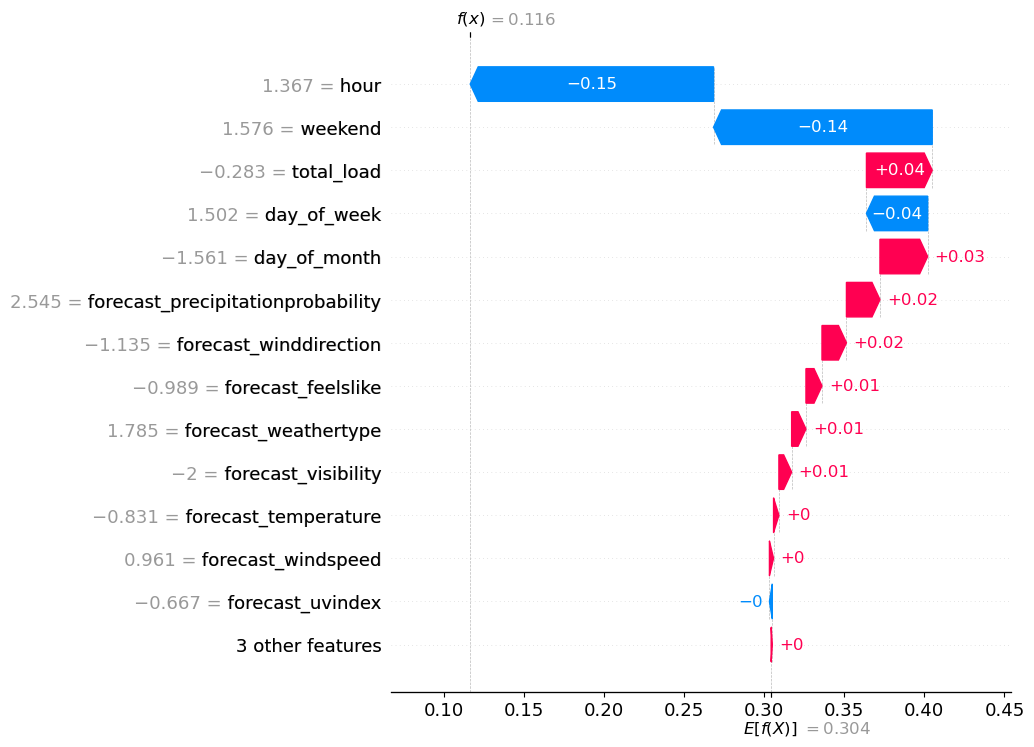

In [186]:
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

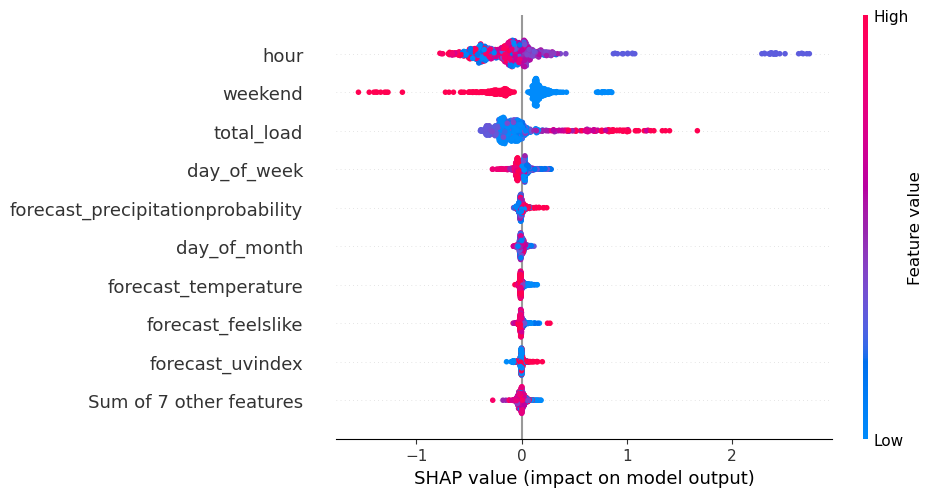

In [187]:
shap.plots.beeswarm(shap_values)

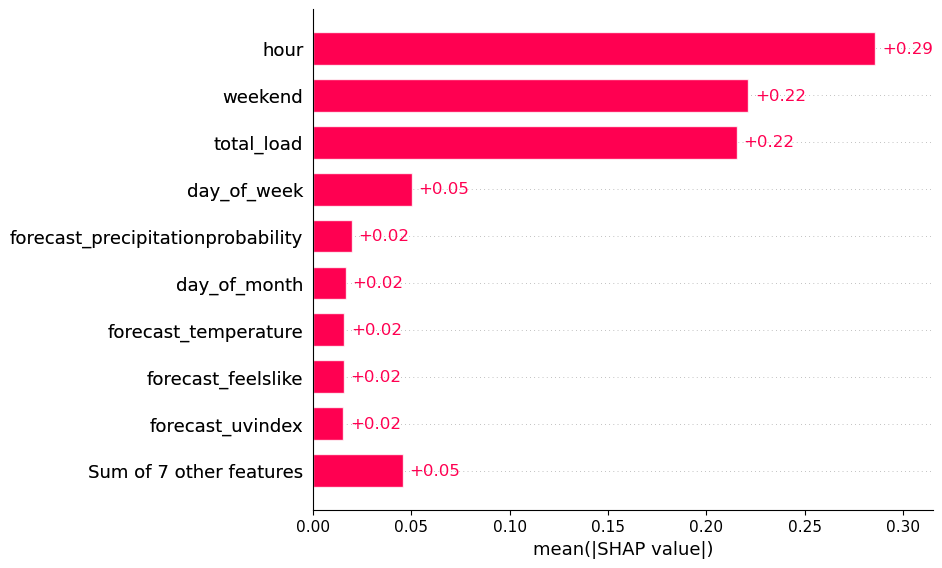

In [188]:
shap.plots.bar(shap_values)

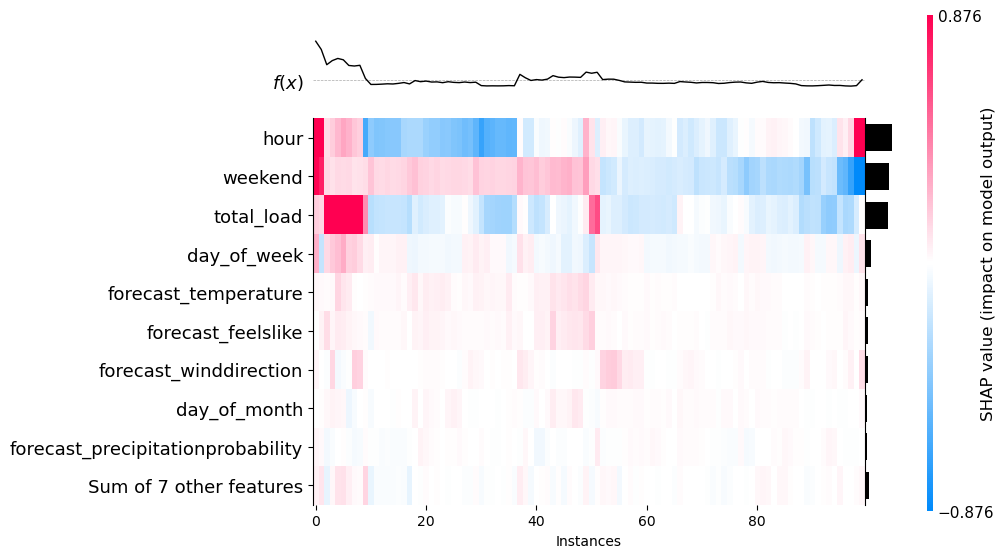

In [189]:
shap.plots.heatmap(shap_values[:100])

#### Without feature selection

In [190]:
rf_reg = RandomForestRegressor()
rf_reg_fit = rf_reg.fit(bldg_train_data[column_name[:-1]], bldg_train_data[column_name[-1]])
bldg_test_data["predictions"] = rf_reg_fit.predict(bldg_test_data[column_name[:-1]])
cal_metrics(bldg_test_data["y"].to_numpy(), bldg_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.472788,140.4,0.507858,127.56,0.103077


#### With feature selection

In [191]:
# features are shortlisted based on the consensus from the feature selection methods
shortlisted_features = ['hour', 'weekend', 'total_load', 'day_of_week', 'forecast_temperature', 'forecast_feelslike'] + ["y"]

In [192]:
rf_reg = RandomForestRegressor()
rf_reg_fit = rf_reg.fit(bldg_train_data[shortlisted_features[:-1]], bldg_train_data[shortlisted_features[-1]])
bldg_test_data["predictions"] = rf_reg_fit.predict(bldg_test_data[shortlisted_features[:-1]])
cal_metrics(bldg_test_data["y"].to_numpy(), bldg_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.577062,140.31,0.13821,121.75,0.1364


### Composite forecasting

####  Model

In [197]:
# comms_model 
comms_shortlisted_features = ['comms_and_services', 'month', 'year', 'forecast_temperature', 'forecast_feelslike'] + ["y"]
comms_model = LinearRegression()
comms_model_fit = comms_model.fit(cs_train_data[comms_shortlisted_features[:-1]], cs_train_data[comms_shortlisted_features[-1]])
cs_test_data["predictions"] = comms_model_fit.predict(cs_test_data[comms_shortlisted_features[:-1]])
cs_test_data[["predictions", "y"]] = cs_target_scaler.inverse_transform(cs_test_data[["predictions", "y"]])
cal_metrics(cs_test_data["y"].to_numpy(), cs_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.001051,0.24,0.313655,0.24,0.124863


In [198]:
# sh model
sh_shortlisted_features = ['space_heating', 'forecast_feelslike', 'forecast_temperature', 'hour', 'forecast_windspeed', "month"] + ["y"]
sh_model = LinearRegression()
sh_model_fit = sh_model.fit(sh_train_data[sh_shortlisted_features[:-1]], sh_train_data[sh_shortlisted_features[-1]])
sh_test_data["predictions"] = sh_model_fit.predict(sh_test_data[sh_shortlisted_features[:-1]])
sh_test_data[["predictions", "y"]] = sh_target_scaler.inverse_transform(sh_test_data[["predictions", "y"]])
cal_metrics(sh_test_data["y"].to_numpy(), sh_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.386874,42.17,0.657622,32.88,0.097229


In [199]:
# all others model
other_shortlisted_features = ['total_load', 'hour', 'weekend', 'day_of_week', 'forecast_temperature', 'forecast_feelslike'] + ["y"]
other_model = RandomForestRegressor()
other_model_fit = other_model.fit(bldg_train_data[other_shortlisted_features[:-1]], bldg_train_data[other_shortlisted_features[-1]])
bldg_test_data["predictions"] = other_model_fit.predict(bldg_test_data[other_shortlisted_features[:-1]])
bldg_test_data[["predictions", "y"]] = bldg_target_scaler.inverse_transform(bldg_test_data[["predictions", "y"]])
cal_metrics(bldg_test_data["y"].to_numpy(), bldg_test_data["predictions"].to_numpy())

,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.336678,51.54,0.103299,45.67,0.139136


In [238]:
# input for the composite model is the prediction output of the other 3 models, preparting the input data for the composite forecasting
input_data = cs_transformed_data.reset_index(drop=0)[["time"]]
tmp_data = data.reset_index(drop=0)[["time", "bld_engcons"]]
input_data = input_data.merge(tmp_data, on="time", how="left")
input_data.head()

,time,bld_engcons
0,2021-01-01 00:00:00+00,4.221002
1,2021-01-01 01:00:00+00,4.806708
2,2021-01-01 02:00:00+00,6.585732
3,2021-01-01 03:00:00+00,6.545530
4,2021-01-01 04:00:00+00,6.211650


In [239]:
input_data["cs_predictions"] = comms_model_fit.predict(cs_transformed_data[comms_shortlisted_features[:-1]])
input_data["cs_predictions"] = cs_target_scaler.inverse_transform(input_data[["cs_predictions"]])

input_data["sh_predictions"] = sh_model_fit.predict(sh_transformed_data[sh_shortlisted_features[:-1]])
input_data["sh_predictions"] = sh_target_scaler.inverse_transform(input_data[["sh_predictions"]])

input_data["others_predictions"] = other_model_fit.predict(bldg_transformed_data[other_shortlisted_features[:-1]])
input_data["others_predictions"] = bldg_target_scaler.inverse_transform(input_data[["others_predictions"]])


In [240]:
input_data = input_data.set_index("time")

In [241]:
input_data.head()

,bld_engcons,cs_predictions,sh_predictions,others_predictions
time,,,,
2021-01-01 00:00:00+00,4.221002,0.591085,3.302769,0.292751
2021-01-01 01:00:00+00,4.806708,0.590801,3.753830,0.583767
2021-01-01 02:00:00+00,6.585732,0.591237,4.780744,0.229602
2021-01-01 03:00:00+00,6.545530,0.590897,5.123318,0.229296
2021-01-01 04:00:00+00,6.211650,0.590968,4.853340,0.574882


In [242]:
input_data = input_data.rename(columns={"bld_engcons": "y"})
col_name = ["cs_predictions", "sh_predictions", "others_predictions", "y"]
input_data = input_data.dropna(axis=0)

In [264]:
train_input_data = input_data[input_data.index < '2023-12-01']
test_input_data = input_data[input_data.index >= '2023-12-01']

In [265]:
composite_model = LinearRegression()
composite_model_fit = composite_model.fit(train_input_data[col_name[:-1]], train_input_data[col_name[-1]])
test_input_data["predictions"] = composite_model.predict(test_input_data[col_name[:-1]])
cal_metrics(test_input_data["y"].to_numpy(), test_input_data["predictions"].to_numpy())

C:\Users\akson\AppData\Local\Temp\ipykernel_12596\3667898465.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,MAE,MAPE,R2_Score,SMAPE,nRMSE
0,0.336461,14.47,0.855007,14.48,0.06803


In [266]:
test_input_data = test_input_data.reset_index(drop=0)

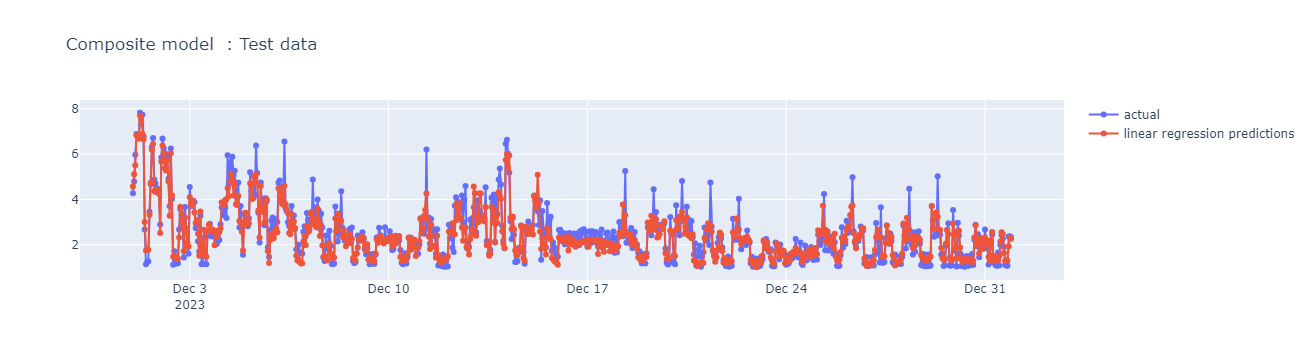

In [267]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_input_data["time"].to_numpy(), y=test_input_data["y"].to_numpy(),
                    mode='lines+markers',
                    name='actual'))
fig.add_trace(go.Scatter(x=test_input_data["time"].to_numpy(), y=test_input_data["predictions"].to_numpy(),
                    mode='lines+markers',
                    name='linear regression predictions'))
fig.update_layout(title_text="Composite model  : Test data")
fig.show()

In [247]:
asset_path = '.././assets/'
file_name = 'composite_model.html'
plotly.offline.plot(fig, filename=asset_path + file_name)

'.././assets/composite_model.html'

#### Interpretation

In [248]:
test_input_data = test_input_data.set_index("time")

In [249]:
test_input_data.head()

,y,cs_predictions,sh_predictions,others_predictions,predictions
time,,,,,
2023-12-01 00:00:00+00,4.272741,0.433358,3.282382,0.604207,4.570363
2023-12-01 01:00:00+00,4.790861,0.432801,3.713871,0.690575,5.117413
2023-12-01 02:00:00+00,5.973732,0.433808,4.296515,0.324009,5.507959
2023-12-01 03:00:00+00,6.885378,0.433657,5.330198,0.549112,6.832834
2023-12-01 04:00:00+00,6.817401,0.434277,5.277446,0.565051,6.785692


In [250]:
X100 = shap.utils.sample(test_input_data[col_name[:-1]], 100)  # 100 instances for use as the background distribution

In [251]:
explainer = shap.Explainer(composite_model_fit.predict, X100)
shap_values = explainer(test_input_data[col_name[:-1]])

In [252]:
sample_ind = 45

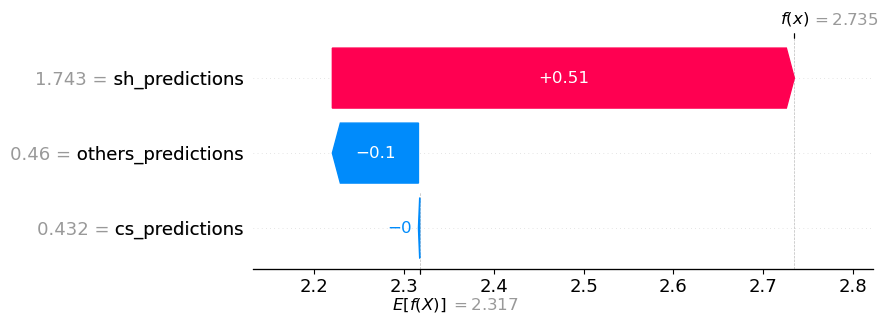

In [253]:
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

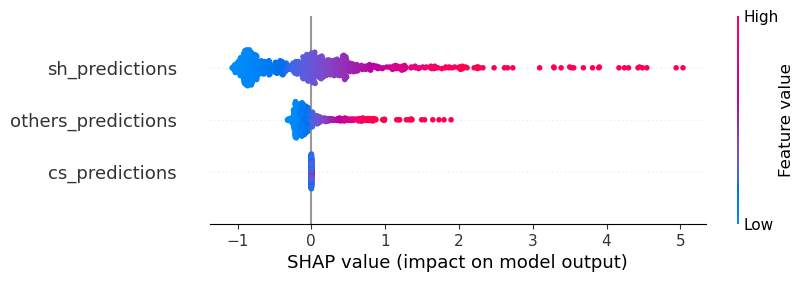

In [254]:
shap.plots.beeswarm(shap_values)

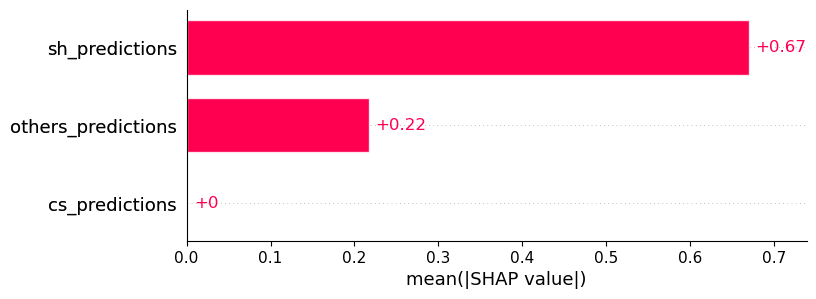

In [255]:
shap.plots.bar(shap_values)

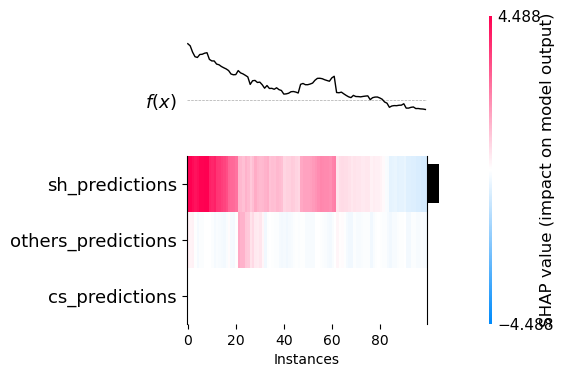

In [256]:
shap.plots.heatmap(shap_values[:100])